In [1]:
# Reference
# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import Dataset

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import numpy as np

import PIL
from PIL import Image

import pickle

In [2]:
########################################################################
# Okay, so what next?
#
# How do we run these neural networks on the GPU?
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor on to the GPU, you transfer the neural
# net onto the GPU.
#
# Let's first define our device as the first visible cuda device if we have
# CUDA available:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
data = unpickle('./curriculum_clustering/input/webvision_cls0-9_batch1')
X = data['images']
img_ids = data['id']
id_to_img = dict()
for i, img_id in enumerate(img_ids):
    id_to_img[img_id] = X[i]

data = unpickle('./curriculum_clustering/input/webvision_cls0-9_batch2')
X = data['images']
img_ids = data['id']
for i, img_id in enumerate(img_ids):
    id_to_img[img_id] = X[i]

print("# img_ids:", len(id_to_img))

# img_ids: 13720


In [25]:
########################################################################
# Custom dataset
# 

class WebvisionDataset(Dataset):
    def __init__(self, id_to_img, num_cluster=3, combine=True, transform=None):
        
        def getCluster(cluster_set, file):
            with open(file) as f:
                metadata_cluster = [x.strip().split(' ') for x in f]

            return cluster_set.union(set([item[0] for item in metadata_cluster]))
            
        cluster_txt = ["1.txt", "2.txt", "3.txt"]
        
        cluster_list = './curriculum_clustering/input/webvision_cls0-9.txt' # webvision train list
        with open(cluster_list) as f:
            metadata = [x.strip().split(' ') for x in f]
        
        metadata_cluster_set = set()
        if combine:
            for i in range(num_cluster):
                cluster = './curriculum_clustering/output-expected-webvision/' + cluster_txt[i]
                metadata_cluster_set = getCluster(metadata_cluster_set, cluster)
        else:
            cluster = './curriculum_clustering/output-expected-webvision/' + cluster_txt[num_cluster-1]
            metadata_cluster_set = getCluster(metadata_cluster_set, cluster)

        X_train = []
        y_train = []
        metadata_train = []
        for i, data in enumerate(metadata):
            file = data[0]
            y = data[1]
            if file in metadata_cluster_set:
                img = id_to_img.get(file, None)
                if img is not None:
                    X_train.append(img)
                    y_train.append(y)
                    metadata_train.append(data)
           
        self.X_train = X_train
        self.y_train = y_train
        self.metadata_train = metadata
        
        print("# X_train:", len(self.X_train))
        print("# y_train:", len(self.y_train))
        for i in range(0,10):
            target = str(i)
            print("% "+target, len([x for x in self.y_train if x==target])/len(self.y_train))
        print()
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        
        label = int(self.y_train[index])
        return img, label

    def __len__(self):
        return len(self.X_train)

In [31]:
transform = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# wv1 = WebvisionDataset(id_to_img, num_cluster=1, combine=False, transform=transform)
# wv2 = WebvisionDataset(id_to_img, num_cluster=2, combine=False, transform=transform)
# wv3 = WebvisionDataset(id_to_img, num_cluster=3, combine=False, transform=transform)
wv1 = WebvisionDataset(id_to_img, num_cluster=1, transform=transform)
wv2 = WebvisionDataset(id_to_img, num_cluster=2, transform=transform)
wv3 = WebvisionDataset(id_to_img, num_cluster=3, transform=transform)

# X_train: 7101
# y_train: 7101
% 0 0.05858329812702436
% 1 0.11758907196169553
% 2 0.09238135473876918
% 3 0.11139276158287566
% 4 0.10646387832699619
% 5 0.11223771299816927
% 6 0.09195887903112238
% 7 0.09956344176876496
% 8 0.09660611181523729
% 9 0.11322348964934516

# X_train: 11619
# y_train: 11619
% 0 0.10431190291763491
% 1 0.0979430243566572
% 2 0.09923401325415268
% 3 0.10121352956364575
% 4 0.09888974954815388
% 5 0.10198812290214304
% 6 0.0973405628711593
% 7 0.09863155176865479
% 8 0.09966434288665117
% 9 0.10078319993114726

# X_train: 13720
# y_train: 13720
% 0 0.1
% 1 0.1
% 2 0.1
% 3 0.1
% 4 0.1
% 5 0.1
% 6 0.1
% 7 0.1
% 8 0.1
% 9 0.1



In [32]:
########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

trainloader_viewer = torch.utils.data.DataLoader(wv1, batch_size=4,
                                          shuffle=True, num_workers=0)

trainloader1 = torch.utils.data.DataLoader(wv1, batch_size=32,
                                          shuffle=True, num_workers=0)

trainloader2 = torch.utils.data.DataLoader(wv2, batch_size=32,
                                          shuffle=True, num_workers=0)

trainloader3 = torch.utils.data.DataLoader(wv3, batch_size=32,
                                          shuffle=True, num_workers=0)

classes = ('tench', 'goldfish', 'great_white_shark', 'tiger_shark',
           'hammerhead_shark', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


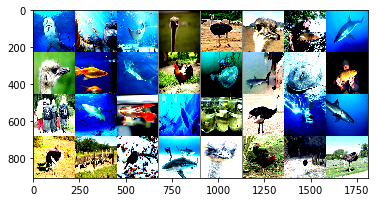

In [30]:
########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader1)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [33]:
# ########################################################################
# # 2. Define a Convolution Neural Network

net = models.squeezenet1_1(pretrained=False)
#net.to(device)

C:\Users\Sophie\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\Sophie\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [34]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Cluster experiment 2 epochs, final loss 1.894

All experiment 2 epochs, final loss, time: 1:45pm to

14,502/32 => 453 iterations

In [12]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

cluster_experiment=True

loaders = []
if cluster_experiment:
    loaders = [trainloader1, trainloader2, trainloader3]
else:
    loaders = [trainloader3]

train_loss = []
modelname = './zoo/webvision-squeezenet1_1'
for it, trainloader in enumerate(loaders):
    print("*** Cluster:", it)
    print("# loaders:", len(loaders))
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        epoch_loss = 0.0
        cnt_loss = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            #inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_loss += loss.item()
            cnt_loss += 1
            every = 10
            if i % every == (every-1):    # print every x mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/every))
                running_loss = 0.0
        
        epoch_loss =/ cnt_loss
        train_loss.append(epoch_loss)
        # validation loss
        
        
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, epoch_loss))

        every_epoch = 1
        if i % every_epoch == (every_epoch-1):    # save every x epochs
            print("save")
            if cluster_experiment:
                filename = modelname+'-loader'+str(it+1)+'_epoch'+str(epoch)+'.pth.tar'
            else:
                filename = modelname+'-loader-all_epoch'+str(epoch)+'.pth.tar'
            torch.save(net, filename)
            
            # save plot loss

print('Finished Training')

*** Cluster: 0
# loaders: 1
[1,    10] loss: 5.534
[1,    20] loss: 3.075
[1,    30] loss: 2.543
[1,    40] loss: 2.390
[1,    50] loss: 2.287
[1,    60] loss: 2.189
[1,    70] loss: 2.085
[1,    80] loss: 2.082
[1,    90] loss: 2.027
[1,   100] loss: 2.120
[1,   110] loss: 1.920
[1,   120] loss: 1.843
[1,   130] loss: 1.937
[1,   140] loss: 2.051
[1,   150] loss: 1.923
[1,   160] loss: 1.929
[1,   170] loss: 2.072
[1,   180] loss: 1.910
[1,   190] loss: 2.077
[1,   200] loss: 1.990
[1,   210] loss: 1.991
[1,   220] loss: 2.082
[1,   230] loss: 1.876
[1,   240] loss: 1.934
[1,   250] loss: 1.878
[1,   260] loss: 1.886
[1,   270] loss: 1.909
[1,   280] loss: 1.957
[1,   290] loss: 1.888
[1,   300] loss: 1.829
[1,   310] loss: 1.879
[1,   320] loss: 1.821
[1,   330] loss: 1.911
[1,   340] loss: 1.797
[1,   350] loss: 1.849
[1,   360] loss: 1.880
[1,   370] loss: 1.863
[1,   380] loss: 1.847
[1,   390] loss: 1.798
[1,   400] loss: 1.789
[1,   410] loss: 1.754
[1,   420] loss: 1.827
[1,   

In [ ]:
def train():
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  tiger_shark goldfish goldfish tiger_shark


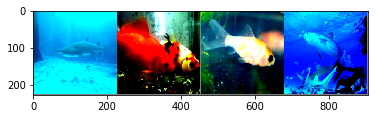

In [76]:
########################################################################
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(trainloader_viewer)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [77]:
########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(images)

In [78]:
########################################################################
# The outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  tiger_shark goldfish tiger_shark tiger_shark


In [18]:
########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
with torch.no_grad():
    for data in trainloader1:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


In [20]:
########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in trainloader1:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        #print(labels)
        #print(c)
        #break
        for i in range(0,len(labels)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    total = class_total[i]
    if total == 0:
        total = 1
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / total))

Accuracy of tench :  0 %
Accuracy of goldfish : 87 %
Accuracy of great_white_shark : 85 %
Accuracy of tiger_shark :  0 %
Accuracy of hammerhead_shark :  6 %
Accuracy of electric_ray :  0 %
Accuracy of stingray :  0 %
Accuracy of  cock : 39 %
Accuracy of   hen :  3 %
Accuracy of ostrich : 81 %


In [84]:
torch.save(net, './zoo/webvision-squeezenet1_1-test.pth.tar')

In [6]:
resnet18 = models.resnet18(pretrained=True)

torch.save(resnet18, './zoo/imagenet-resnet18.pth.tar')